# CNN + MaxPool
Try again 10 rounds of train/test but don't rely on save/load.

In [1]:
from datetime import datetime
print(datetime.now())

2023-03-15 17:52:18.290621


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64
FILTERSIZE=16
RCELLS=32
DCELLS=16
EPOCHS=12
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
MINLEN=200
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'RCI_GMM'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
CACHING = False   # have not worked out how to cache multiple cell lines
NUM_LINES = 15   # 15 to analyze all of them

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = 'train.lncRNA_RCI.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = np.power(values,2)
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = 0.0
                        else:
                            log_mean = np.log2(big_mean) 
                        gene_to_rci[gene_id] = log_mean
        print('Number of RCI values loaded',len(gene_to_rci.keys()))
        return gene_to_rci

    def seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        return allids,allseq

## Model

In [7]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    flat_layer = Flatten()
    dens_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool_layer)
    cnn.add(flat_layer)
    cnn.add(dens_layer)
    cnn.add(drop_layer)
    cnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return cnn

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-15 17:52:49.893367
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 4982, 64)          4160      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 621, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 39744)             0         
                                                                 
 dense (Dense)               (None, 16)                635920    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                             

## Training

In [12]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def set_sequences(self, allids, allseq):
        # Keep IDs and sequences in same order.
        self.all_ids = allids  # pairs of (gene_id,tran_id)
        self.all_seqs = allseq  # may be vectors of K-mers
        genes = []
        for i in range(len(allids)):
            (one_gene,one_tran) = allids[i]
            genes.append(one_gene)
        self.all_genes = genes
            
    def set_rci_map(self, gene_to_rci):
        # The map is for fast lookup, not gene order.
        self.rci_map = gene_to_rci # map gene_id to RCI value
    
    def _get_gene_subset(self, sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = self.all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes   # this is a set: unordered with fast lookup
    
    def _get_X_y(self, gene_index, exclude_middle=False):
        # gene_index is ndarray with subset of indices of all_genes
        subsetX=[]
        subsetY=[]
        gene_subset = self._get_gene_subset(gene_index)
        for t in range(len(self.all_ids)):
            gene_id,tran_id = self.all_ids[t]
            if gene_id in gene_subset:
                oneX            = self.all_seqs[t]
                oneY            = self.rci_map[gene_id]
                if exclude_middle and oneY >= -2 and oneY <= 0:
                    # Exclude middle from train set only, for comparison to Yuan et al
                    continue
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_without_validation(self):
        print(datetime.now())
        # For final train, do not test or evaluate.
        # Assume set_sequences() set the traom set.
        train_index = range(len(self.all_ids))  
        X_train,y_rci = self._get_X_y(train_index) 
        self._prepare_threshold(y_rci,True)  # create and save
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        y_rci = None
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # validation_data=(X_valid,y_valid) ) 
        
    def test_without_training(self):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        test_index = range(len(self.all_ids))  
        X_test,y_rci = self._get_X_y(test_index) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.2f%%' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

2023-03-15 17:57:23.412408
2023-03-15 17:57:23.413959
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.1.train.all_lncRNA_transcripts.csv
Loaded 15436 sequences.

Training # 1 1
2023-03-15 17:57:48.033689
2023-03-15 17:57:48.035408
Discriminator is GMM
Means [1.5018060533253388, -0.12149087262199547]
Variances [2.34967046 6.63837502]
Priors [0.68826566 0.31173434]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-15 17:58:01.340105

2023-03-15 17:59:25.669519
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.1.valid.all_lncRNA_transcripts.csv
Loade

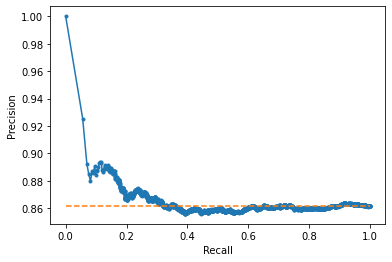

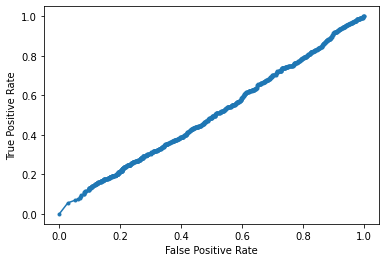

Accuracy: 74.49% Precision: 85.93% Recall: 84.17%
F1: 85.04% MCC: -0.02%
AUPRC: 87.07% AUROC: 50.15%
 accuracy [74.48900388098319]
 precision [85.92887798896382]
 recall [84.17417417417418]
 F1 [85.04247572815532]
 MCC [-0.015419557813980344]
 AUPRC [87.06911972776969]
 AUROC [50.15388285481743]
2023-03-15 17:59:36.083978
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.2.train.all_lncRNA_transcripts.csv
Loaded 15719 sequences.

Training # 1 2
2023-03-15 18:00:01.274552
2023-03-15 18:00:01.277769
Discriminator is GMM
Means [1.4003118375656065, -0.16843676120740347]
Variances [2.41131152 7.87302737]
Priors [0.73191025 0.26808975]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-15 18:00:16.155996

2023-03-15 18:01:14.806109
Load RCI fro

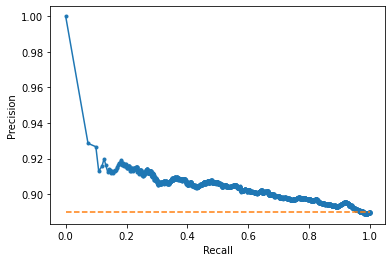

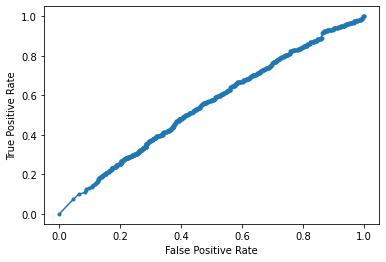

Accuracy: 81.88% Precision: 89.41% Recall: 90.34%
F1: 89.87% MCC: 0.04%
AUPRC: 90.85% AUROC: 55.25%
 accuracy [81.88163037409268]
 precision [89.40993788819875]
 recall [90.33573893944148]
 F1 [89.87045419072889]
 MCC [0.04163763527392639]
 AUPRC [90.85450392692252]
 AUROC [55.24698835856109]
2023-03-15 18:01:23.874035
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.3.train.all_lncRNA_transcripts.csv
Loaded 15617 sequences.

Training # 1 3
2023-03-15 18:01:48.615264
2023-03-15 18:01:48.617544
Discriminator is GMM
Means [-0.2350005959171423, 1.4376198708465082]
Variances [8.24199299 2.3650325 ]
Priors [0.25193062 0.74806938]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-15 18:02:01.372310

2023-03-15 18:03:25.187834
Load RCI from /c

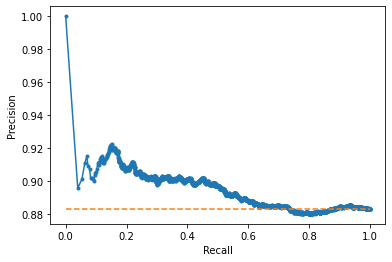

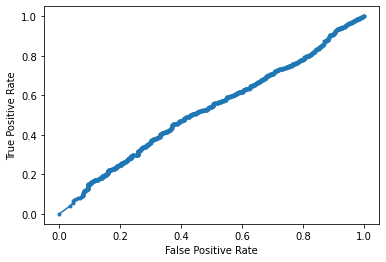

Accuracy: 75.60% Precision: 88.09% Recall: 83.68%
F1: 85.83% MCC: -0.01%
AUPRC: 89.67% AUROC: 52.92%
 accuracy [75.5971769815418]
 precision [88.09061488673139]
 recall [83.67660620965263]
 F1 [85.82689579063535]
 MCC [-0.014912290559162423]
 AUPRC [89.66658442862305]
 AUROC [52.917635193785074]
2023-03-15 18:03:34.722650
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.4.train.all_lncRNA_transcripts.csv
Loaded 15033 sequences.

Training # 1 4
2023-03-15 18:03:59.710980
2023-03-15 18:03:59.713558
Discriminator is GMM
Means [1.452780382302602, -0.2622650416442887]
Variances [2.35245377 8.74239411]
Priors [0.75836095 0.24163905]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
FIT
2023-03-15 18:04:11.689088

2023-03-15 18:05:35.632585
Load RCI from 

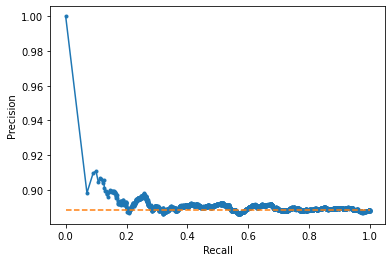

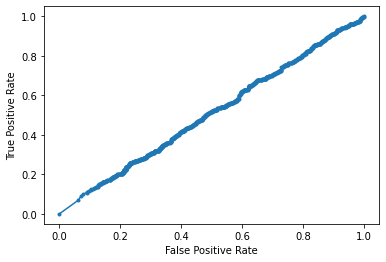

Accuracy: 80.34% Precision: 88.92% Recall: 88.95%
F1: 88.94% MCC: 0.01%
AUPRC: 89.54% AUROC: 50.83%
 accuracy [80.34208059981256]
 precision [88.92405063291139]
 recall [88.94750725402268]
 F1 [88.93577739680865]
 MCC [0.008980162908137499]
 AUPRC [89.53692028319136]
 AUROC [50.82895216354303]
2023-03-15 18:05:45.706482
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.5.train.all_lncRNA_transcripts.csv
Loaded 15399 sequences.

Training # 1 5
2023-03-15 18:06:08.120161
2023-03-15 18:06:08.123209
Discriminator is GMM
Means [1.4411161003551427, -0.15108927153802026]
Variances [2.50253942 7.7529317 ]
Priors [0.70656257 0.29343743]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-15 18:06:20.503286

2023-03-15 18:07:18.538153
Load RCI from 

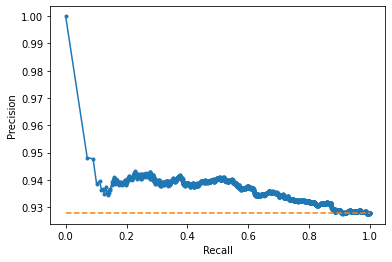

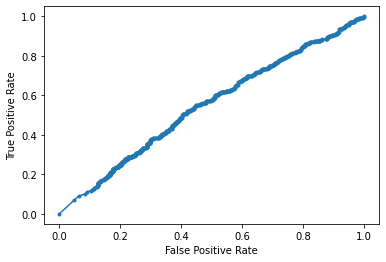

Accuracy: 83.73% Precision: 92.88% Recall: 89.31%
F1: 91.06% MCC: 0.01%
AUPRC: 93.89% AUROC: 54.81%
 accuracy [83.72629420809841]
 precision [92.8756104567653]
 recall [89.30939226519337]
 F1 [91.05759752147586]
 MCC [0.011401914023860442]
 AUPRC [93.89053133988264]
 AUROC [54.813144077426436]
2023-03-15 18:07:26.596828
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.1.train.all_lncRNA_transcripts.csv
Loaded 15931 sequences.

Training # 2 1
2023-03-15 18:07:51.607980
2023-03-15 18:07:51.610270
Discriminator is GMM
Means [-0.15920053272097565, 1.4933632201719762]
Variances [6.67785608 2.39988992]
Priors [0.31250179 0.68749821]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-15 18:08:06.758688

2023-03-15 18:09:30.559414
Load RCI from 

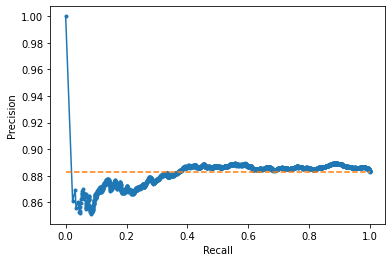

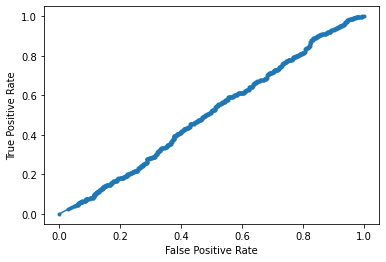

Accuracy: 65.46% Precision: 88.55% Recall: 69.93%
F1: 78.14% MCC: 0.01%
AUPRC: 88.21% AUROC: 50.79%
 accuracy [65.459940652819]
 precision [88.55319148936171]
 recall [69.9260752688172]
 F1 [78.14494930529477]
 MCC [0.011553964514143212]
 AUPRC [88.21031571161005]
 AUROC [50.78709199825337]
2023-03-15 18:09:37.753138
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.2.train.all_lncRNA_transcripts.csv
Loaded 15132 sequences.

Training # 2 2
2023-03-15 18:10:02.892152
2023-03-15 18:10:02.895002
Discriminator is GMM
Means [-0.08314872408883776, 1.4250208504204003]
Variances [7.693823   2.43569276]
Priors [0.29995216 0.70004784]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-15 18:10:17.926372

2023-03-15 18:11:41.705927
Load RCI from /co

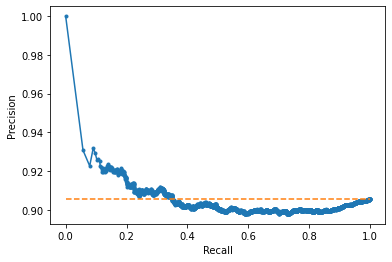

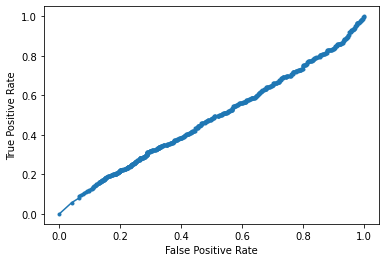

Accuracy: 77.55% Precision: 89.95% Recall: 84.66%
F1: 87.23% MCC: -0.05%
AUPRC: 90.89% AUROC: 48.12%
 accuracy [77.54857279923243]
 precision [89.95215311004785]
 recall [84.66225165562913]
 F1 [87.22707423580788]
 MCC [-0.049023938472110895]
 AUPRC [90.89134736176545]
 AUROC [48.11806232561267]
2023-03-15 18:11:51.448609
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.3.train.all_lncRNA_transcripts.csv
Loaded 15080 sequences.

Training # 2 3
2023-03-15 18:12:15.499443
2023-03-15 18:12:15.501915
Discriminator is GMM
Means [-0.3253928528653713, 1.4315237398229543]
Variances [9.27624558 2.39906181]
Priors [0.21382552 0.78617448]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
FIT
2023-03-15 18:12:29.348515

2023-03-15 18:13:53.080645
Load RCI from

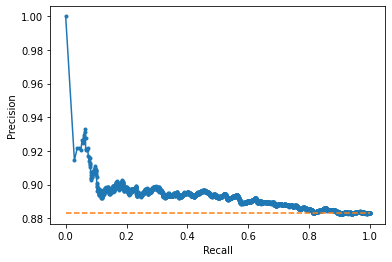

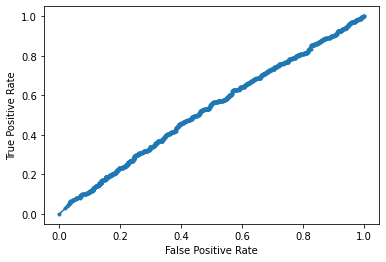

Accuracy: 75.01% Precision: 88.41% Recall: 82.51%
F1: 85.36% MCC: 0.01%
AUPRC: 89.48% AUROC: 52.88%
 accuracy [75.0059227671168]
 precision [88.41288096607246]
 recall [82.50603702709954]
 F1 [85.35739070090216]
 MCC [0.007825384969504919]
 AUPRC [89.48008797078954]
 AUROC [52.87906175419768]
2023-03-15 18:14:02.763487
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.4.train.all_lncRNA_transcripts.csv
Loaded 15369 sequences.

Training # 2 4
2023-03-15 18:14:26.863575
2023-03-15 18:14:26.866323
Discriminator is GMM
Means [-0.2746228970429069, 1.4527425984839477]
Variances [8.39617686 2.31519292]
Priors [0.25544924 0.74455076]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-15 18:14:43.170010

2023-03-15 18:15:40.600965
Load RCI from /c

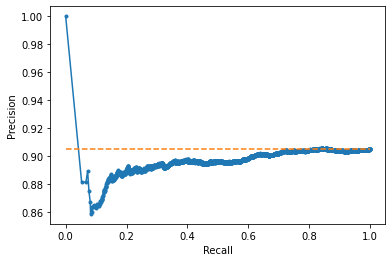

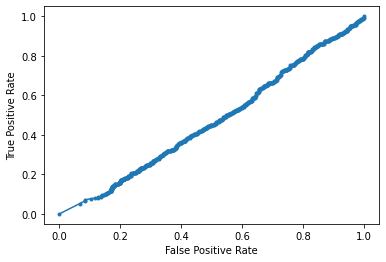

Accuracy: 68.97% Precision: 90.25% Recall: 73.66%
F1: 81.12% MCC: -0.01%
AUPRC: 89.78% AUROC: 46.90%
 accuracy [68.97253306205494]
 precision [90.2548209366391]
 recall [73.66498032602586]
 F1 [81.12039616217889]
 MCC [-0.013376007658731098]
 AUPRC [89.78009884740032]
 AUROC [46.895186865179916]
2023-03-15 18:15:50.291983
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.5.train.all_lncRNA_transcripts.csv
Loaded 15692 sequences.

Training # 2 5
2023-03-15 18:16:15.964000
2023-03-15 18:16:15.967007
Discriminator is GMM
Means [-0.13410390502391403, 1.4834775160075986]
Variances [7.03001438 2.36344798]
Priors [0.30648048 0.69351952]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-15 18:16:31.153682

2023-03-15 18:17:30.086766
Load RCI fro

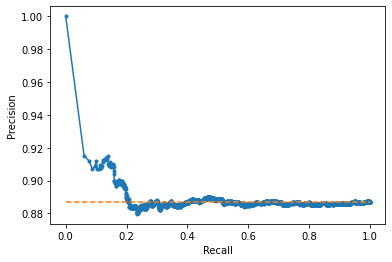

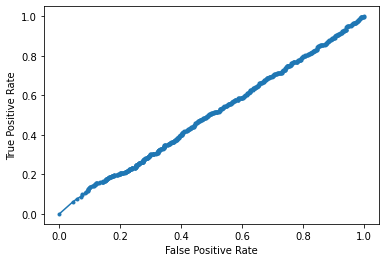

Accuracy: 79.47% Precision: 88.58% Recall: 88.22%
F1: 88.40% MCC: -0.01%
AUPRC: 89.33% AUROC: 50.04%
 accuracy [79.46799667497922]
 precision [88.58218318695107]
 recall [88.22243049047172]
 F1 [88.40194083581154]
 MCC [-0.009797918375256705]
 AUPRC [89.33457605829425]
 AUROC [50.03679150510564]
2023-03-15 18:17:38.639018


In [13]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1
        TRAIN_FILE = 'cv.{}.{}.train.all_lncRNA_transcripts.csv'.format(r,f)
        VALID_FILE = 'cv.{}.{}.valid.all_lncRNA_transcripts.csv'.format(r,f)
        
        print(datetime.now())
        loader = DataLoader()
        filepath = DATA_DIR+RCI_FILE_TRAIN
        print("Load RCI from",filepath)
        gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
        print('Num RCI:', len(gene_to_rci.keys()))
        filepath = DATA_DIR+TRAIN_FILE
        print('Load sequence from',filepath)
        allids,allseq = loader.load_sequence(filepath)
        print('Loaded',len(allseq),'sequences.')
        loader = None  # drop K-mer cache to save RAM
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_sequences(allids,allseq)
        cvdo.set_rci_map(gene_to_rci)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_without_validation()
        #filepath = DATA_DIR+GMM_FILE
        #cvdo.save_gmm(filepath)
        #filepath = DATA_DIR+CNN_FILE
        #cvdo.save_cnn(filepath)

        print()
        print(datetime.now())
        loader = DataLoader()
        filepath = DATA_DIR+RCI_FILE_TEST
        print("Load RCI from",filepath)
        gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
        print('Num RCI:', len(gene_to_rci.keys()))
        filepath = DATA_DIR+VALID_FILE
        print('Load sequence from',filepath)
        allids,allseq = loader.load_sequence(filepath)
        print('Loaded',len(allseq),'sequences.')
        loader = None  # drop K-mer cache to save RAM

        print()
        print("Testing #",r,f)
        print(datetime.now())
        #cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
        cvdo.set_sequences(allids,allseq)
        cvdo.set_rci_map(gene_to_rci)
        #cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        #filepath = DATA_DIR+GMM_FILE
        #cvdo.load_gmm(filepath)
        #filepath = DATA_DIR+CNN_FILE
        #cvdo.load_cnn(filepath)
        cvdo.reset_statistics()
        cvdo.test_without_training()
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
print(datetime.now())

In [14]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 76.25% std 5.68
 precision mean 89.10% std 1.78
 recall mean 83.54% std 6.80
 F1 mean 86.10% std 3.99
 MCC mean -0.00% std 0.02
 AUPRC mean 89.87% std 1.81
 AUROC mean 51.27% std 2.71
 accuracy [[74.48900388098319], [81.88163037409268], [75.5971769815418], [80.34208059981256], [83.72629420809841], [65.459940652819], [77.54857279923243], [75.0059227671168], [68.97253306205494], [79.46799667497922]]
 precision [[85.92887798896382], [89.40993788819875], [88.09061488673139], [88.92405063291139], [92.8756104567653], [88.55319148936171], [89.95215311004785], [88.41288096607246], [90.2548209366391], [88.58218318695107]]
 recall [[84.17417417417418], [90.33573893944148], [83.67660620965263], [88.94750725402268], [89.30939226519337], [69.9260752688172], [84.66225165562913], [82.50603702709954], [73.66498032602586], [88.22243049047172]]
 F1 [[85.04247572815532], [89.87045419072889], [85.82689579063535], [88.93577739680865], [91.05759752147586], [78.14494930529477], [87.22707423580